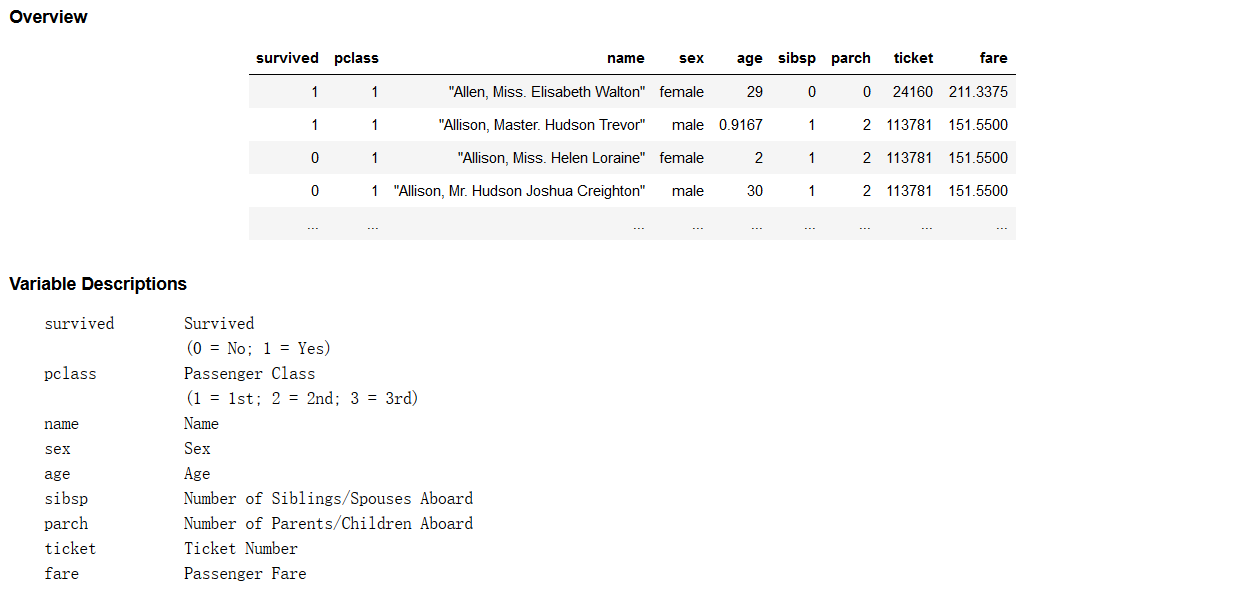

In [2]:
from __future__ import absolute_import, division, print_function

import csv
import requests
import tensorflow as tf

## Create TFRecords

In [3]:
# Generate Integer Features.
def build_int64_feature(data):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[data]))

# Generate Float Features.
def build_float_feature(data):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[data]))

# Generate String Features.
def build_string_feature(data):
    data = data.encode('utf-8') if type(data) == str else data
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[data]))

# Generate a TF `Example`, parsing all features of the dataset.
def convert_to_tfexample(survived, pclass, name, sex, age, sibsp, parch, ticket, fare):
    return tf.train.Example(
        features=tf.train.Features(
            feature={
                'survived': build_int64_feature(survived),
                'pclass': build_int64_feature(pclass),
                'name': build_string_feature(name),
                'sex': build_string_feature(sex),
                'age': build_float_feature(age),
                'sibsp': build_int64_feature(sibsp),
                'parch': build_int64_feature(parch),
                'ticket': build_string_feature(ticket),
                'fare': build_float_feature(fare),
            })
    )

In [ ]:
# Open dataset file.
with open("./titanic_dataset.csv") as f:
    # Output TFRecord file.
    with tf.io.TFRecordWriter("titanic_dataset.tfrecord") as w:
        # Generate a TF Example for all row in our dataset.
        # CSV reader will read and parse all rows.
        reader = csv.reader(f, skipinitialspace=True)
        for i, record in enumerate(reader):
            # Skip header.
            if i == 0:
                continue
            survived, pclass, name, sex, age, sibsp, parch, ticket, fare = record
            # Parse each csv row to TF Example using the above functions.
            example = convert_to_tfexample(int(survived), int(pclass), name, sex, float(age), int(sibsp), int(parch), ticket, float(fare))
            # Serialize each TF Example to string, and write to TFRecord file.
            w.write(example.SerializeToString())

之后会生成 titanic_dataset.tfrecord 文件

## Load TFRecords

In [ ]:
# Build features template, with types.
features = {
    'survived': tf.io.FixedLenFeature([], tf.int64),
    'pclass': tf.io.FixedLenFeature([], tf.int64),
    'name': tf.io.FixedLenFeature([], tf.string),
    'sex': tf.io.FixedLenFeature([], tf.string),
    'age': tf.io.FixedLenFeature([], tf.float32),
    'sibsp': tf.io.FixedLenFeature([], tf.int64),
    'parch': tf.io.FixedLenFeature([], tf.int64),
    'ticket': tf.io.FixedLenFeature([], tf.string),
    'fare': tf.io.FixedLenFeature([], tf.float32),
}

In [ ]:
# Create TensorFlow session.
sess = tf.Session()

# Load TFRecord data.
filenames = ["titanic_dataset.tfrecord"]
data = tf.data.TFRecordDataset(filenames)

# Parse features, using the above template.
def parse_record(record):
    return tf.io.parse_single_example(record, features=features)
# Apply the parsing to each record from the dataset.
data = data.map(parse_record)

# Refill data indefinitely.
data = data.repeat()
# Shuffle data.
data = data.shuffle(buffer_size=1000)
# Batch data (aggregate records together).
data = data.batch(batch_size=4)
# Prefetch batch (pre-load batch for faster consumption).
data = data.prefetch(buffer_size=1)

# Create an iterator over the dataset.
iterator = data.make_initializable_iterator()
# Initialize the iterator.
sess.run(iterator.initializer)

# Get next data batch.
x = iterator.get_next()

In [ ]:
# Dequeue data and display.
for i in range(3):
    print(sess.run(x))
    print("")

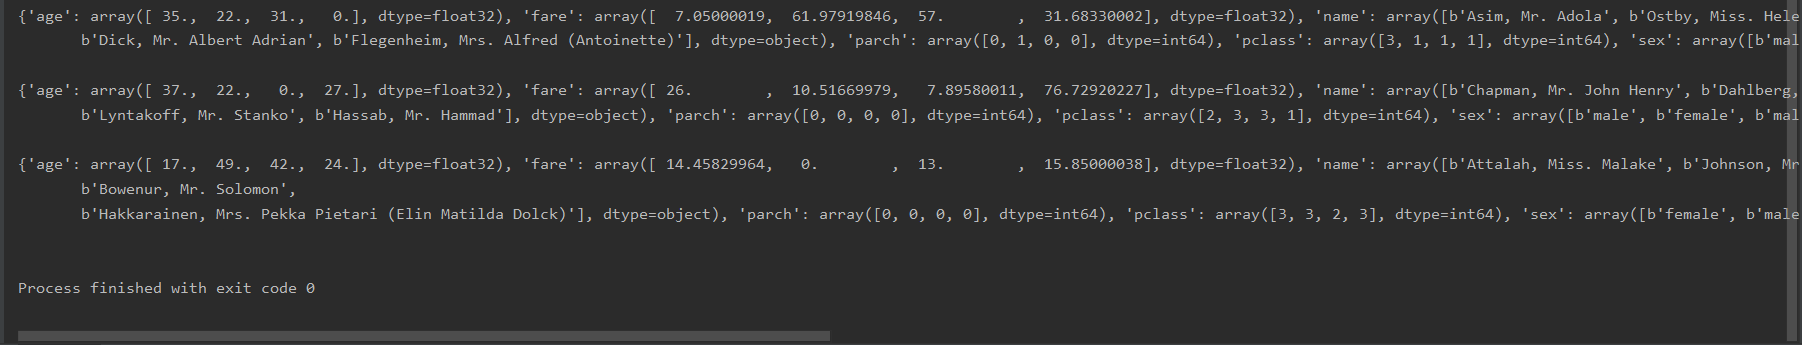